# **DATA PREPROCESSING**

Below, our group will report on the issues we encountered during the data preprocessing stage and how we handled them.

### **Issues encountered during the data processing:**

In [586]:
import pandas as pd
import numpy as np 
import csv
import re
from difflib import SequenceMatcher
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

From the input file (containing raw data crawled from the web), we will perform data preprocessing steps to clean the data, and then output the results into an output file (containing the cleaned data after all preprocessing steps).

In [587]:
# Đường dẫn tới file CSV đầu vào 
file_input = '../Data/temp_data.csv'
# Đường dẫn tới file CSV đầu ra
file_output = '../Data/clean_data.csv'

#### **Issue 01:**

When initially crawling data from the web (raw data), I encountered an error that prevented the execution of the `pd.read_csv` command. Upon a preliminary inspection, I discovered that the error was due to extra quotation marks in the data string, which caused the data structure to be incorrect.

In [588]:
# Hàm sửa lỗi dư hoặc thiếu dấu ngoặc kép trong file CSV
def fix_csv_quotes(file_input, file_output):
    # Mở file đầu vào để đọc và file đầu ra để ghi
    with open(file_input, 'r', encoding = 'utf-8') as infile, open(file_output, 'w', newline = '', encoding = 'utf-8') as outfile:
        # Đọc tất cả các dòng từ file đầu vào
        reader = infile.readlines()
        # Tạo writer để ghi vào file đầu ra
        writer = csv.writer(outfile)

        # Lặp qua từng dòng trong file đầu vào
        for line in reader:
            # Kiểm tra số lượng dấu ngoặc kép trong dòng
            num_quotes = line.count('"')
            # Nếu số lượng dấu ngoặc kép là số lẻ, thêm một dấu ngoặc kép ở cuối dòng
            if num_quotes % 2 != 0:
                line = line.strip() + '"\n'
            # Ghi lại dòng đã sửa vào file đầu ra
            writer.writerow(next(csv.reader([line], skipinitialspace = True)))

Use the `fix_csv_quotes` function to appropriately adjust the pairs of quotation marks (" ") in the data.

In [589]:
fix_csv_quotes(file_input, file_output)

#### **Issue 02:**

The data in the columns of the CSV file is not clean; specifically, there are unnecessary characters and special characters that could significantly impact subsequent processes.

In [590]:
column_index = 8  # Chỉ số của cột cần làm sạch (bắt đầu từ 0), cột 8 là cột Description

def clean_string(string):

    """
    Hàm này sẽ làm sạch chuỗi bằng cách loại bỏ các biểu tượng và ký tự không cần thiết.
    (nhưng giữ lại các kí tự chữ (hoa và thường), số, dấu chấm, dấu phẩy, dấu | )
    
    string: Chuỗi cần làm sạch.
    cleanString: Chuỗi đã được làm sạch.

    """

    # Hàm isinstance check xem data input của mình có phải là string không 
    if isinstance(string, str):
        cleanString = re.sub(r'[^\w\s.,|]', '', string) # Xoá tất cả các kí tự ngoại trừ chữ (thường, hoa), số, dấu chấm, dấu phẩy, dấu |
        return cleanString
    else:
        return string

In [591]:
def clean_file_csv(file_input, file_output, column_index):

    """
    Hàm này sẽ làm sạch một cột cụ thể trong file CSV, do có những cột khác (VD cột Postdate có dấu : ), 
    Vì vậy nếu apply full file csv nó sẽ fix hết cả những cột không cần thiết -> chỉ áp dụng chính xác cột cần xử lí thôi.

    input_csv (str): Đường dẫn tới file CSV đầu vào (temp_data).
    output_csv (str): Đường dẫn tới file CSV đầu ra (clean_data).
    column_index (int): Chỉ số của cột cần làm sạch.
    """

    # Đọc file CSV vào DataFrame
    df = pd.read_csv(file_input, on_bad_lines = 'skip')

    # Kiểm tra xem chỉ số cột có hợp lệ không
    if column_index < len(df.columns):
        # Áp dụng hàm làm sạch cho cột cụ thể
        col = df.columns[column_index]
        df[col] = df[col].apply(clean_string)
    else:
        print(f"Invalid column index !")

    # Lưu lại DataFrame đã được làm sạch thành file CSV mới
    df.to_csv(file_output, index = False)



In [592]:
clean_file_csv(file_input, file_output, column_index)

#### **Issue 03:**

Extract data from the **`Title`** and **`Description`** fields to fill in the positions where the data is null using `regular expressions` (regex).

In [593]:
# Đọc lại file csv, xoá các dòng bị lỗi 
# (mình nhận thấy số lượng dòng bị lỗi không nhiều ~ 10 dòng nên mình sẽ skip luôn vì tụi mình có nhiều data mà =))))
df = pd.read_csv('../Data/clean_data.csv', on_bad_lines = 'skip')

In [594]:
# Thay thế "Thoả thuận" bằng NaN cho dễ xử lí về sau (tạm thời)
df['Price'] = df['Price'].replace('TT', np.nan)

In [595]:
# Biểu thức chính quy để trích xuất thông tin giá
price_pattern = re.compile(
    r'Giá[^0-9]*([0-9]+[.,]?[0-9]*)\s*(Tỷ|Triệu)', 
    re.IGNORECASE
)
# 'Giá' - Tìm từ "Giá"
# '[^0-9]*' - Không chứa ký tự số
# '([0-9]+[.,]?[0-9]*)' - Nhóm các số, có thể có dấu phẩy hoặc dấu chấm
# '\s*' - Bỏ qua các khoảng trắng
# '(Tỷ|Triệu)' - Tìm từ "Tỷ" hoặc "Triệu"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường

# Biểu thức chính quy để trích xuất thông tin diện tích
area_pattern = re.compile(
    r'(\d+\.?\d*)\s*x\s*(\d+\.?\d*)|\((\d+\.?\d*)m2\)',
    re.IGNORECASE
)
# '(\d+\.?\d*)\s*x\s*(\d+\.?\d*)' - Tìm diện tích dưới dạng "chiều dài x chiều rộng"
# '(\d+\.?\d*)' - Nhóm tìm các số, có thể có dấu chấm thập phân
# '\s*x\s*' - Tìm ký tự "x", có thể có khoảng trắng
# '(\d+\.?\d*)' - Nhóm tìm các số phía sau ký tự "x"
# '|' - Hoặc
# '\((\d+\.?\d*)m2\)' - Tìm diện tích dưới dạng "(xxx m2)"
# '\(' - Dấu mở ngoặc đơn
# '(\d+\.?\d*)' - Nhóm tìm các số, có thể có dấu chấm thập phân
# 'm2' - Ký tự "m2"
# '\)' - Dấu đóng ngoặc đơn
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường

# Biểu thức chính quy để trích xuất thông tin số phòng ngủ
bedroom_pattern = re.compile(
    r'(\d+)\s*PN',
    re.IGNORECASE
)
# '(\d+)' - Nhóm tìm một hoặc nhiều chữ số
# '\s*' - Bỏ qua các khoảng trắng
# 'PN' - Tìm từ "PN" (phòng ngủ)
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường

# Biểu thức chính quy để trích xuất thông tin số nhà vệ sinh
wc_pattern = re.compile(
    r'(\d+)\s*WC',
    re.IGNORECASE
)
# '(\d+)' - Nhóm tìm một hoặc nhiều chữ số
# '\s*' - Bỏ qua các khoảng trắng
# 'WC' - Tìm từ "WC" (nhà vệ sinh)
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường

# Biểu thức chính quy để trích xuất thông tin số tầng
floor_pattern = re.compile(
    r'(\d+)\s*(lầu|tầng|tang|tâng|lau|lâu|sàn lầu)',
    re.IGNORECASE
)
# '(\d+)' - Nhóm tìm một hoặc nhiều chữ số
# '\s*' - Bỏ qua các khoảng trắng
# '(lầu|tầng)' - Tìm từ "lầu" hoặc "tầng"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường
legal_pattern = re.compile(
    r'\b(pháp lý|sổ|so hong|phap ly)\b',
    re.IGNORECASE)
#\b: Ký tự biên (word boundary), đảm bảo rằng từ được tìm kiếm là từ độc lập, không phải là một phần của từ khác.
#(pháp lý|sổ): Nhóm các từ cần tìm kiếm, cụ thể là "sổ", "pháp lý", "sổ hồng"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường
frontage_pattern = re.compile(r'\b(mặt tiền|hẻm|mat tien|hem)\b', re.IGNORECASE)
#\b: Ký tự biên (word boundary), đảm bảo rằng từ được tìm kiếm là từ độc lập, không phải là một phần của từ khác.
#(pmặt tiền|hẻm|mat tien|hem): Nhóm các từ cần tìm kiếm, cụ thể là "mặt tiền", ""hẻm"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường

In [596]:
# Hàm để kiểm tra xem một câu có chứa các cụm từ "xây được", "xây", "được xây" hay không
def contains_build_phrase(text):
    return bool(re.search(r'\b(xây được|xây|được xây)\b', text, re.IGNORECASE))

In [597]:
# Hàm để loại bỏ các số sau cụm từ "xây được", "xây", "được xây"
def remove_numbers(text):
    pattern = re.compile(r'\b(xây được|xây|được xây)\b.*?(\d+)', re.IGNORECASE)
    return pattern.sub(r'\1', text)

In [598]:
# Hàm để xử lý các trường hợp đặc biệt như "1 trệt 1 lầu", "1 trệt 1 lửng"
def special_cases(text):
    if re.search(r'\b1 trệt 1 lầu\b', text, re.IGNORECASE):
        return 2
    if re.search(r'\b1 trệt 1 lửng\b', text, re.IGNORECASE):
        return 1
    return None

In [599]:
# Hàm để trích xuất thông tin từ một chuỗi văn bản
def extract_info(text):
    # Kiểm tra nếu text là None hoặc NaN thì gán giá trị rỗng
    if text is None or pd.isna(text):
        text = ''  # Khởi tạo giá trị rỗng nếu text là None hoặc NaN
    # Nếu text không phải là chuỗi, chuyển đổi nó sang chuỗi
    elif not isinstance(text, str):
        text = str(text)  # Chuyển đổi giá trị sang chuỗi nếu không phải là chuỗi
    
    # Loại bỏ các số sau cụm từ "xây được", "xây", "được xây"
    filtered_text = remove_numbers(text)
    
    # Kiểm tra các trường hợp đặc biệt
    floors = special_cases(filtered_text)
    
    # Nếu không có trường hợp đặc biệt, tiếp tục trích xuất thông tin thông thường
    if floors is None:
        # Tìm kiếm các mẫu trong text
        price_match = price_pattern.search(filtered_text)
        area_match = area_pattern.search(filtered_text)
        bedroom_match = bedroom_pattern.search(filtered_text)
        wc_match = wc_pattern.search(filtered_text)
        legal_match = legal_pattern.search(filtered_text)
        frontage_match = frontage_pattern.search(filtered_text)
        
        # Trích xuất số tầng nếu tìm thấy
        floor_matches = floor_pattern.findall(filtered_text)
        if floor_matches:
            for match in floor_matches:
                floor_count = int(match[0])
                if match[1].lower() in ['lầu', 'lau', 'lâu', 'sàn lầu']:
                    floors = floor_count + 1  # Tăng giá trị lên 1 nếu là "lầu"
                    break
                elif match[1].lower() in ['tầng', 'tang', 'tâng']:
                    if floor_count > 15:
                        lầu_match = re.search(r'(\d+)\s*(lầu|lau|lâu|sàn lầu)', filtered_text, re.IGNORECASE)
                        if lầu_match:
                            floors = int(lầu_match.group(1)) + 1
                            break
                    else:
                        floors = floor_count
        
        price = None
        # Nếu tìm thấy giá
        if price_match:
            number = price_match.group(1).replace(',', '.')
            unit = price_match.group(2)
            # Chuyển đổi giá trị sang VND dựa trên đơn vị
            if unit and unit.lower() in ['tỷ', 'tỷ', 'tỉ']:
                price = float(number) * 1_000_000_000  # Chuyển đổi tỷ sang VND
            elif unit and unit.lower() in ['triệu', 'triệu']:
                price = float(number) * 1_000_000  # Chuyển đổi triệu sang VND
            else:
                price = float(number)  # Nếu không có đơn vị, chỉ trả về số dưới dạng float
        
        area = None
        # Nếu tìm thấy diện tích
        if area_match:
            if area_match.group(3):
                area = float(area_match.group(3))  # Diện tích tổng (150m2)
            else:
                width = float(area_match.group(1))
                length = float(area_match.group(2))
                area = width * length  # Tính diện tích từ chiều dài và chiều rộng
        
        # Trích xuất số phòng ngủ nếu tìm thấy
        bedrooms = bedroom_match.group(1) if bedroom_match else None
        # Trích xuất số nhà vệ sinh nếu tìm thấy
        wcs = wc_match.group(1) if wc_match else None
        legal = 1 if legal_match else None
        frontage = 1 if frontage_match and frontage_match.group(0).lower() in ['mặt tiền', 'mat tien'] else 0 if frontage_match and frontage_match.group(0).lower() in ['hẻm', 'hem'] else None
    else:
        # Gán giá trị mặc định cho các thông tin khác nếu không có thông tin từ văn bản
        price = None
        area = None
        bedrooms = None
        wcs = None
        legal = None
        frontage = None
    
    # Trả về kết quả dưới dạng Series của pandas
    return pd.Series([price, area, bedrooms, wcs, floors, legal, frontage ])

In [600]:
# Hàm để trích xuất thông tin từ cả 'Title' và 'Description'
def extract_info_from_row(row):
    title_info = extract_info(row['Title'])
    description_info = extract_info(row['Description'])
    
    # Nếu thông tin từ Description không có, lấy thông tin từ Title
    final_info = title_info.combine_first(description_info)
    
    return final_info

In [601]:
if 'Floors' not in df.columns:
    df['Floors'] = None
if 'Legal_status' not in df.columns:
    df['Legal_status'] = None
if 'Frontage' not in df.columns:
    df['Frontage'] = None

In [602]:
# Áp dụng hàm extract_info_from_row lên từng hàng của DataFrame và lưu kết quả vào các cột mới
df[['Extracted_Price', 'Extracted_Area', 'Extracted_Bedrooms', 'Extracted_WCs', 'Extracted_Floors', 'Extracted_Legal_status', 'Extracted_Frontage']] = df.apply(extract_info_from_row, axis=1)

# Chuyển đổi cột 'Price' sang kiểu số, nếu có lỗi thì gán giá trị NaN
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Cập nhật cột 'Price' theo điều kiện: nếu 'Price' ban đầu là NaN hoặc lớn hơn 1000 thì lấy giá trị từ 'Extracted_Price'
df['Price'] = df.apply(lambda row: row['Extracted_Price'] if pd.isnull(row['Price']) or row['Price'] > 1000 else row['Price'], axis=1)

# Hàm để điền thông tin số phòng ngủ (bedrooms), số nhà vệ sinh (WCs) và số tầng (floors) từ các giá trị đã trích xuất
def fill_info(row):
    if pd.isnull(row['Bedrooms']):
        row['Bedrooms'] = row['Extracted_Bedrooms']  # Nếu 'Bedrooms' ban đầu là NaN thì lấy giá trị từ 'Extracted_Bedrooms'
    if pd.isnull(row['WCs']):
        row['WCs'] = row['Extracted_WCs']  # Nếu 'WCs' ban đầu là NaN thì lấy giá trị từ 'Extracted_WCs'
    if pd.isnull(row['Floors']):
        row['Floors'] = row['Extracted_Floors']  # Nếu 'Floors' ban đầu là NaN thì lấy giá trị từ 'Extracted_Floors'
    if pd.isnull(row['Legal_status']):
        row['Legal_status'] = row['Extracted_Legal_status']  # Nếu 'Legal_status' ban đầu là NaN thì lấy giá trị từ 'Extracted_Legal_status'
    if pd.isnull(row['Frontage']):
        row['Frontage'] = row['Extracted_Frontage']  # Nếu 'Frontage' ban đầu là NaN thì lấy giá trị từ 'Extracted_Frontage'

    return row

# Áp dụng hàm fill_info lên từng hàng của DataFrame
df = df.apply(fill_info, axis = 1)

# Xuất DataFrame mới ra file CSV
df.to_csv(file_output, index = False)

C:\Users\Phuong\AppData\Local\Temp\ipykernel_21732\1363349392.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_info = title_info.combine_first(description_info)
C:\Users\Phuong\AppData\Local\Temp\ipykernel_21732\1363349392.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_info = title_info.combine_first(description_info)
C:\Users\Phuong\AppData\Local\Temp\ipykernel_21732\1363349392.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when d

In [603]:
print(df.head())

   No  Price                                              Title  Area  \
0   1    NaN  Cửa gỗ công nghiệp MDF laminate cao cấp tại Qu...   NaN   
1   2    NaN   ��The power of online advertising facebook ads��   NaN   
2   3    NaN  ��️ Email/SMS Marketing - Sustainable communic...   NaN   
3   4   13.5  Siêu rẻ ! Nhà 1 Đời Chủ, 2 MT Hoàng Sa, Q1, Đo...  44.0   
4   5    NaN  Maxads - leading the trend of MULTIMEDIA ADVER...   NaN   

  Bedrooms   WCs District             Postdate  \
0      NaN   NaN   quan-1  2023-11-22 11:08:20   
1     None  None   quan-1  2023-11-23 10:27:56   
2     None  None   quan-1  2023-11-24 09:44:58   
3      NaN   NaN   quan-1  2023-11-24 16:39:03   
4     None  None   quan-1  2023-11-25 09:55:56   

                                         Description  Floors  Legal_status  \
0   |HOTLINE  zalo 035.312.6411  0888.696.029 NVK...     NaN           NaN   
1  advertising forms quotas a springboardquot bec...     NaN           NaN   
2  interaction strategy. C

In [604]:
# Loại bỏ cột No và cột Title không cần thiết 
df = df.drop(columns = df.columns[[0, 2]])

In [605]:
print(df)

             Price   Area Bedrooms   WCs District             Postdate  \
0              NaN    NaN      NaN   NaN   quan-1  2023-11-22 11:08:20   
1              NaN    NaN     None  None   quan-1  2023-11-23 10:27:56   
2              NaN    NaN     None  None   quan-1  2023-11-24 09:44:58   
3     1.350000e+01   44.0      NaN   NaN   quan-1  2023-11-24 16:39:03   
4              NaN    NaN     None  None   quan-1  2023-11-25 09:55:56   
...            ...    ...      ...   ...      ...                  ...   
9979  7.000000e+00  170.0      NaN   NaN  thu-duc  2022-10-27 16:24:29   
9980  3.300000e+00   40.0      4.0   2.0  thu-duc  2022-10-27 14:48:46   
9981  1.300000e+01   52.8      4.0   5.0  thu-duc  2022-10-27 09:36:50   
9982  5.600000e+09  112.0      3.0   2.0  thu-duc  2022-10-26 22:29:32   
9983  6.000000e+00  100.0      NaN   NaN  thu-duc  2022-10-25 13:03:53   

                                            Description  Floors  Legal_status  \
0      |HOTLINE  zalo 035.312.

#### **Issue 04:**

Perform detailed processing, calculations, and filling of missing values. Additionally, add a feature called **`Price_per_sqm`** (price per square meter).

In [606]:
# Chuyển đổi các cột 'Price' và 'Area' sang kiểu số (float) để thực hiện các bước xử lí, tính toán dễ dàng hơn.
df['Price'] = df['Price'].astype(float)
df['Area'] = df['Area'].astype(float)

In [607]:
# Hàm xử lý cột Price
def process_price(df):
    def convert_price(price):
        if pd.isnull(price):
            return price
        price = float(price)
        if price > 1e9:
            return price / 1e9  # Nếu giá trị lớn hơn 1 tỷ, chuyển sang đơn vị tỷ
        elif price > 1e6:
            return price / 1e6  # Nếu giá trị lớn hơn 1 triệu, chuyển sang đơn vị triệu
        elif price > 1e3:
            return price / 1e3  # Nếu giá trị lớn hơn 1 nghìn, chuyển sang đơn vị nghìn
        return price  # Trả về giá trị gốc nếu nhỏ hơn 1 nghìn
    
    df['Price'] = df['Price'].apply(convert_price)  # Áp dụng hàm convert_price cho cột 'Price'
    return df

df = process_price(df)

# Hàm tính giá trên một mét vuông
def price_per_sqm(df):
    df['Price_per_sqm'] = df.apply(lambda row: row['Price'] / row['Area'] if pd.notnull(row['Price']) and pd.notnull(row['Area']) else np.nan, axis = 1)
    # Tạo cột 'Price_per_sqm' bằng cách lấy 'Price' chia cho 'Area' nếu cả hai đều không bị null, ngược lại trả về NaN
    return df


# Hàm điền giá trị thiếu
def fill_miss_vals(df):
    # Tính giá trị trung bình của 'Price', 'Area', và 'Price_per_sqm' theo 'District'
    district_means = df.groupby('District').mean(numeric_only = True)
    
    # Điền giá trị thiếu cho 'Price' bằng giá trị trung bình của 'District'
    for idx, row in df.iterrows():
        if pd.isnull(row['Price']):
            df.at[idx, 'Price'] = district_means.loc[row['District'], 'Price']
    
    # Tính lại giá trên một mét vuông
    df = price_per_sqm(df)
    
    # Điền giá trị thiếu cho 'Area' và 'Price' dựa trên 'Price_per_sqm'
    for idx, row in df.iterrows():
        if pd.isnull(row['Area']) and pd.notnull(row['Price']):
            df.at[idx, 'Area'] = row['Price'] / row['Price_per_sqm']  # Tính diện tích dựa trên giá trị 'Price' và 'Price_per_sqm'
        elif pd.isnull(row['Price']) and pd.notnull(row['Area']):
            df.at[idx, 'Price'] = row['Area'] * row['Price_per_sqm']  # Tính giá trị 'Price' dựa trên 'Area' và 'Price_per_sqm'
        elif pd.isnull(row['Price']) and pd.isnull(row['Area']):
            df.at[idx, 'Price'] = district_means.loc[row['District'], 'Price']  # Điền 'Price' bằng giá trị trung bình của quận
            df.at[idx, 'Area'] = district_means.loc[row['District'], 'Area']  # Điền 'Area' bằng giá trị trung bình của quận
    
    
    # Xử lý các giá trị 'Area' vẫn còn thiếu
    for idx, row in df.iterrows():
        if pd.isnull(row['Area']):  
            df.at[idx, 'Area'] = district_means.loc[row['District'], 'Area']

    # Điền giá trị thiếu cho 'Price_per_sqm' nếu còn thiếu
    for idx, row in df.iterrows():
        if pd.isnull(row['Price_per_sqm']) and pd.notnull(row['Price']) and pd.notnull(row['Area']):
            df.at[idx, 'Price_per_sqm'] = row['Price'] / row['Area']  # Tính lại 'Price_per_sqm' nếu thiếu và các giá trị khác không bị null
    

    # Làm tròn các giá trị vừa điền vào
    df['Price'] = df['Price'].round(2)  # Làm tròn giá trị 'Price' đến 2 chữ số thập phân
    df['Area'] = df['Area'].round(2)  # Làm tròn giá trị 'Area' đến 2 chữ số thập phân
    df['Price_per_sqm'] = df['Price_per_sqm'].round(2)  # Làm tròn giá trị 'Price_per_sqm' đến 2 chữ số thập phân

    return df

In [608]:
# Kiểm tra giá trị null trong cột 'Area' và 'Price'
null_area = df['Area'].isnull().sum()
print(null_area)
null_price = df['Price'].isnull().sum()
print(null_price)

1012
858


In [609]:
# Thêm cột giá trên 1 mét vuông
df = price_per_sqm(df)

For the purpose of discarding unreasonable data.

In [610]:
# Hàm để cập nhật cột Price theo điều kiện price_per_sqm > 1
def update_price(row):
    # Kiểm tra nếu 'Area' không phải là None và lớn hơn 0
    if row['Area'] and row['Area'] > 0:  # Đảm bảo diện tích không phải là None hoặc 0
        # Tính giá trên mỗi mét vuông
        price_per_sqm = row['Price'] / row['Area']
        # Nếu giá trên mỗi mét vuông lớn hơn 1
        if price_per_sqm > 1:
            # Trả về giá trị từ 'Extracted_Price'
            return row['Extracted_Price']
    # Nếu không thỏa mãn điều kiện, trả về giá trị ban đầu của 'Price'
    return row['Price']

# Áp dụng hàm update_price lên từng hàng của DataFrame
df['Price'] = df.apply(update_price, axis = 1)

In [611]:
# Điền giá trị thiếu cho 'Price' và 'Area'
df = fill_miss_vals(df)

In [612]:
# Thực hiện xử lí các giá trị ở cột Price để dữ liệu chuẩn hơn, hợp lý hơn.
df = process_price(df)

#### **Issue 05:**

The next issue with the data is that there are too many duplicate rows.

Initially, after using Python's built-in command to remove duplicates `drop_duplicates()` (removing rows that are 100% identical), I realized that many duplicates still remained due to the following reasons:
* The same house was posted multiple times with different descriptions.
* The same house was posted at different times or on different dates.
* ...

These reasons caused the duplicates not to be completely removed, as Python's built-in function only deletes rows that are 100% identical. Since the **`Postdate`** and **`Description`** fields had slight differences, the built-in function `drop_duplicates()` could not effectively handle this.

The following tasks we handled focused on the **`Postdate`** and **`Description`** 

In [613]:
# Xử lí cột Postdate (chỉ giữ lại Ngày xoá Giờ)
# Chuyển đổi cột 'Postdate' sang kiểu datetime
df['Postdate'] = pd.to_datetime(df['Postdate'])

# Tạo một cột mới chỉ chứa ngày
df['Date'] = df['Postdate'].dt.date

# Tìm vị trí (index) của cột 'Postdate'
col_index = df.columns.get_loc('Postdate')

# Xóa cột 'Postdate' cũ 
df = df.drop(columns = ['Postdate'])

# Chèn cột 'Date' mới vào đúng vị trí cũ của cột 'Postdate'
df.insert(col_index, 'Postdate', df.pop('Date'))

In [614]:
# Load lại những thay đổi vào file clean_data.csv
df.to_csv(file_output, index = False)

At this point, after running the program, an additional error appeared (Unusual line terminators). After some research, we found a solution using the `remove_unusual_line_terminators` function.

In [615]:
def remove_unusual_line_terminators(file_input, file_output):
    with open(file_input, 'r', encoding='utf-8') as infile:
        content = infile.read()

    # Loại bỏ các ký tự kết thúc dòng không bình thường (LS và PS)
    cleaned_content = content.replace('\u2028', '\n').replace('\u2029', '\n')

    with open(file_output, 'w', encoding='utf-8', newline='') as outfile:
        outfile.write(cleaned_content)

Remove all duplicate rows.

In [616]:
def remove_duplicates(df):
    # Đảm bảo rằng các giá trị trong 'Postdate' và 'Description' là chuỗi
    df['Postdate'] = df['Postdate'].astype(str)
    df['Description'] = df['Description'].astype(str)
    
    # Bước 1: Loại bỏ các dòng trùng lặp mà tất cả các cột đều giống nhau
    df = df.drop_duplicates()
    
    # Bước 2: Nhóm các dòng theo các cột 'Price', 'Area', 'Bedrooms', 'WCs', 'District'
    grouped = df.groupby(['Price', 'Area', 'Bedrooms', 'WCs', 'District'], dropna = False)
    
    # Danh sách các chỉ số của các dòng cần giữ lại
    indices_to_keep = set(df.index)

    def similar(a, b):
        return SequenceMatcher(None, a, b).ratio()
    
    # Lặp qua từng nhóm để kiểm tra sự tương đồng
    for _, group in grouped:
        group_indices = list(group.index)
        for i in range(len(group_indices)):
            for j in range(i + 1, len(group_indices)):
                idx1, idx2 = group_indices[i], group_indices[j]
                row1, row2 = df.loc[idx1], df.loc[idx2]
                # Kiểm tra sự tương đồng của 'Description' và ngày 'Postdate'
                postdate_similarity = similar(row1['Postdate'], row2['Postdate'])
                description_similarity = similar(row1['Description'], row2['Description'])
                if postdate_similarity > 0.75 and description_similarity > 0.5:
                    indices_to_keep.discard(idx2)
    
    # Chuyển đổi tập hợp các chỉ số cần giữ lại thành danh sách
    indices_to_keep = list(indices_to_keep)
    
    # Lọc lại DataFrame với các chỉ số cần giữ lại
    df_cleaned = df.loc[indices_to_keep].reset_index(drop=True)
    
    # Trả về DataFrame đã loại bỏ các dòng trùng lặp
    return df_cleaned

In [617]:
# Áp dụng hàm remove_duplicates lên DataFrame đã được làm sạch
df = remove_duplicates(df)

#### **Issue 06:**

Old posts can cause inaccuracies with the current timeframe, so we decided to delete outdated data (specifically, house sale posts from 2022).

In [618]:
# Xem kiểu dữ liệu của cột "Postdate"
df['Postdate'].dtype

dtype('O')

In [619]:
# Chuyển kiểu dữ liệu của cột "Postdate" sang dạng datetime và check lại kiểu dữ liệu 1 lần nữa
df['Postdate'] = pd.to_datetime(df['Postdate'])
df['Postdate'].dtype

dtype('<M8[ns]')

In [620]:
# Loại bỏ các data có ngày đăng tin là 2022 và lưu lại vào file csv
df = df[df['Postdate'].dt.year != 2022]

#### **Issue 07:**

After the above data processing steps, upon re-evaluating the data, we noticed that some data entries were still unreasonable. Therefore, we proceeded to delete these unreasonable data entries.

In [621]:
def remove_invalid(df):
    return df[(df['Price_per_sqm'] <= 2) & (df['Price_per_sqm'] >= 0.03)]

df = remove_invalid(df)

We noticed that house prices were not reasonable in some areas, so we adjusted the prices to be more accurate.

In [622]:
# Danh sách các quận cần điều chỉnh
districts = ['binh-chanh', 'binh-tan', 'hoc-mon', 'cu-chi', 'tan-binh', 'quan-8', 'quan-12']

def adjust_price(row):
    if any(district in row['District'] for district in districts) and row['Price_per_sqm'] > 1:
        return row['Price'] / 1_000
    return row['Price']

# Áp dụng hàm adjust_price_for_district
df['Price'] = df.apply(adjust_price, axis = 1)


In [623]:
cols_drop = ['Extracted_Price', 'Extracted_Area', 'Extracted_Bedrooms', 'Extracted_WCs', 'Extracted_Floors', 'Extracted_Legal_status','Extracted_Frontage']
# Xóa các cột
df = df.drop(columns = cols_drop)

In [624]:
# Tạo lại cột No
df.insert(0, 'No', range(1, len(df) + 1))

In [625]:
# Lưu lại DataFrame vào file CSV
df.to_csv(file_output, index = False)

In [626]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_values

No                  0
Price               0
Area                0
Bedrooms         1814
WCs              2088
District            0
Postdate            0
Description         0
Floors           1357
Legal_status     2738
Frontage         1922
Price_per_sqm       0
dtype: int64

#### **Issue 08:**

Encode the District column into numerical values and extract the month from the Postdate column.

In [627]:
# Encode cột District
# Đầu tiên, xác định các giá trị duy nhất trong cột District
district_unique_values = df['District'].unique()

# Tạo một ánh xạ từ tên quận thành các giá trị số
district_mapping = {district: i for i, district in enumerate(district_unique_values)}

# Áp dụng ánh xạ vào cột District
df['District_encoded'] = df['District'].map(district_mapping)

# Encode cột Postdate thành tháng
df['Month'] = df['Postdate'].dt.month

print(df.head())

   No  Price   Area Bedrooms  WCs District   Postdate  \
3   1   13.5   44.0      NaN  NaN   quan-1 2023-11-24   
6   2    8.7   45.0      3.0  3.0   quan-1 2023-11-27   
7   3   21.5   64.0      NaN  NaN   quan-1 2023-11-27   
8   4    9.3   40.0      4.0  4.0   quan-1 2023-11-29   
9   5  130.0  455.0      NaN  NaN   quan-1 2023-10-25   

                                         Description  Floors  Legal_status  \
3  Chủ kẹt cần bán gấp nhà 2 MT Hoàng Sa, Phường ...     5.0           NaN   
6   Vị trí khu vực ngay đường Trần Hưng Đạo, đối ...     4.0           1.0   
7   Vị trí trung tâm Quận 1, khách thượng lưu và ...     NaN           1.0   
8   Kết cấu 1 trệt, 2 lầu, sân thượng, 3 PN, 4WC....     4.0           1.0   
9   Diện tích 13 x 35m. | Hiện trạng Nhà cấp 4. |...    13.0           NaN   

   Frontage  Price_per_sqm  District_encoded  Month  
3       1.0           0.31                 0     11  
6       0.0           0.19                 0     11  
7       1.0           0.34

In [628]:
# Hiển thị thống kê mô tả cho các cột số
print(df.describe())

                No        Price         Area                       Postdate  \
count  6233.000000  6233.000000  6233.000000                           6233   
mean   3117.000000     9.939126    80.057101  2023-06-30 01:11:09.404781312   
min       1.000000     0.124000     5.000000            2023-01-01 00:00:00   
25%    1559.000000     4.300000    46.000000            2023-04-06 00:00:00   
50%    3117.000000     5.950000    61.290000            2023-07-05 00:00:00   
75%    4675.000000     9.800000    88.000000            2023-09-22 00:00:00   
max    6233.000000   510.000000  2035.000000            2023-12-10 00:00:00   
std    1799.456446    18.978577    83.977329                            NaN   

            Floors  Legal_status     Frontage  Price_per_sqm  \
count  4876.000000        3495.0  4311.000000    6233.000000   
mean      3.210829           1.0     0.368824       0.123035   
min       1.000000           1.0     0.000000       0.030000   
25%       2.000000           1.0

In [629]:
# Hiển thị số lượng giá trị thiếu cho mỗi cột
print(df.isnull().sum())

No                     0
Price                  0
Area                   0
Bedrooms            1814
WCs                 2088
District               0
Postdate               0
Description            0
Floors              1357
Legal_status        2738
Frontage            1922
Price_per_sqm          0
District_encoded       0
Month                  0
dtype: int64


In [630]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6233 entries, 3 to 8892
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   No                6233 non-null   int64         
 1   Price             6233 non-null   float64       
 2   Area              6233 non-null   float64       
 3   Bedrooms          4419 non-null   object        
 4   WCs               4145 non-null   object        
 5   District          6233 non-null   object        
 6   Postdate          6233 non-null   datetime64[ns]
 7   Description       6233 non-null   object        
 8   Floors            4876 non-null   float64       
 9   Legal_status      3495 non-null   float64       
 10  Frontage          4311 non-null   float64       
 11  Price_per_sqm     6233 non-null   float64       
 12  District_encoded  6233 non-null   int64         
 13  Month             6233 non-null   int32         
dtypes: datetime64[ns](1), float64

#### **Issue 09:**

Trained K-Nearest Neighbors (KNN) models to predict missing values for Floors, Bedrooms and WCs in dataset using features: Area, Price per square meter, District (encoded), and Month

In [631]:
# Chọn các đặc trưng
features = ['Price', 'Area', 'Price_per_sqm', 'District_encoded', 'Month']

# Chuyển đổi 'Floors' thành số, lỗi chuyển đổi thành NaN
df['Floors'] = pd.to_numeric(df['Floors'], errors='coerce')

# Loại bỏ các dòng có giá trị thiếu trong các đặc trưng và target
data_floors = df.dropna(subset=['Floors'] + features)

# Chia dữ liệu thành các tập huấn luyện và kiểm tra
X_floors = data_floors[features]
y_floors = data_floors['Floors']
X_floors_train, X_floors_test, y_floors_train, y_floors_test = train_test_split(X_floors, y_floors, test_size=0.2, random_state=42)

# Huấn luyện mô hình KNN cho Floors
knn_floors = KNeighborsRegressor(n_neighbors=5)
knn_floors.fit(X_floors_train, y_floors_train)


KNeighborsRegressor()

In [632]:
# Dự đoán giá trị Floors
floors_predicted = knn_floors.predict(X_floors_test)

# Đánh giá mô hình
mse_floors = mean_squared_error(y_floors_test, floors_predicted)
print(f'Mean Squared Error for Floors: {mse_floors}')

# Dự đoán giá trị thiếu cho Floors trong toàn bộ dữ liệu
floors_missing_indices = df[df['Floors'].isnull()].index
X_floors_missing = df.loc[floors_missing_indices, features]
floors_missing_predicted = knn_floors.predict(X_floors_missing)

# Làm tròn giá trị đã dự đoán về số nguyên gần nhất
floors_missing_predicted_rounded = [round(value) for value in floors_missing_predicted]

# Điền các giá trị đã dự đoán và làm tròn vào cột tương ứng
df.loc[floors_missing_indices, 'Floors'] = floors_missing_predicted_rounded


Mean Squared Error for Floors: 1.3494262295081967


In [633]:
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors='coerce')
df['WCs'] = pd.to_numeric(df['WCs'], errors='coerce')

In [634]:
# Chọn các đặc trưng bao gồm cả 'Floors'
features_with_floors = ['Price', 'Area', 'Price_per_sqm', 'District_encoded', 'Month', 'Floors']

# Loại bỏ các dòng có giá trị thiếu trong các đặc trưng và target
data_bedrooms_wcs = df.dropna(subset=['Bedrooms', 'WCs'] + features_with_floors)

# Chia dữ liệu thành các tập huấn luyện và kiểm tra cho Bedrooms
X_bedrooms = data_bedrooms_wcs[features_with_floors]
y_bedrooms = data_bedrooms_wcs['Bedrooms']
X_bedrooms_train, X_bedrooms_test, y_bedrooms_train, y_bedrooms_test = train_test_split(X_bedrooms, y_bedrooms, test_size=0.2, random_state=42)

# Huấn luyện mô hình KNN cho Bedrooms
knn_bedrooms = KNeighborsRegressor(n_neighbors=5)
knn_bedrooms.fit(X_bedrooms_train, y_bedrooms_train)

# Dự đoán giá trị Bedrooms
bedrooms_predicted = knn_bedrooms.predict(X_bedrooms_test)

# Đánh giá mô hình
mse_bedrooms = mean_squared_error(y_bedrooms_test, bedrooms_predicted)
print(f'Mean Squared Error for Bedrooms: {mse_bedrooms}')

# Chia dữ liệu thành các tập huấn luyện và kiểm tra cho WCs
y_wcs = data_bedrooms_wcs['WCs']
X_wcs_train, X_wcs_test, y_wcs_train, y_wcs_test = train_test_split(X_bedrooms, y_wcs, test_size=0.2, random_state=42)

# Huấn luyện mô hình KNN cho WCs
knn_wcs = KNeighborsRegressor(n_neighbors=5)
knn_wcs.fit(X_wcs_train, y_wcs_train)



Mean Squared Error for Bedrooms: 5.372005044136191


KNeighborsRegressor()

In [635]:

# Dự đoán giá trị WCs
wcs_predicted = knn_wcs.predict(X_wcs_test)

# Đánh giá mô hình
mse_wcs = mean_squared_error(y_wcs_test, wcs_predicted)
print(f'Mean Squared Error for WCs: {mse_wcs}')

# Dự đoán và điền giá trị thiếu cho Bedrooms và WCs trong toàn bộ dữ liệu
bedrooms_missing_indices = df[df['Bedrooms'].isnull()].index
X_bedrooms_missing = df.loc[bedrooms_missing_indices, features_with_floors]
bedrooms_missing_predicted = knn_bedrooms.predict(X_bedrooms_missing)

wcs_missing_indices = df[df['WCs'].isnull()].index
X_wcs_missing = df.loc[wcs_missing_indices, features_with_floors]
wcs_missing_predicted = knn_wcs.predict(X_wcs_missing)

# Làm tròn giá trị đã dự đoán về số nguyên gần nhất
bedrooms_missing_predicted_rounded = [round(value) for value in bedrooms_missing_predicted]
wcs_missing_predicted_rounded = [round(value) for value in wcs_missing_predicted]

# Điền các giá trị đã dự đoán và làm tròn vào cột tương ứng
df.loc[bedrooms_missing_indices, 'Bedrooms'] = bedrooms_missing_predicted_rounded
df.loc[wcs_missing_indices, 'WCs'] = wcs_missing_predicted_rounded

Mean Squared Error for WCs: 5.873392181588903


In [636]:
# Đặt các giá trị None cho cột Legal và Frontage thành -1
df['Legal_status'] = df['Legal_status'].fillna(-1)
# -1 tức là không có thông tin

df['Frontage'] = df['Frontage'].fillna(-1)
# -1 tức là không có thông tin

In [637]:
# Hiển thị số lượng giá trị thiếu cho mỗi cột
print(df.isnull().sum())

No                  0
Price               0
Area                0
Bedrooms            0
WCs                 0
District            0
Postdate            0
Description         0
Floors              0
Legal_status        0
Frontage            0
Price_per_sqm       0
District_encoded    0
Month               0
dtype: int64


#### **Issue 10:**

Exploratory Data Analysis (EDA) and Data Preparation

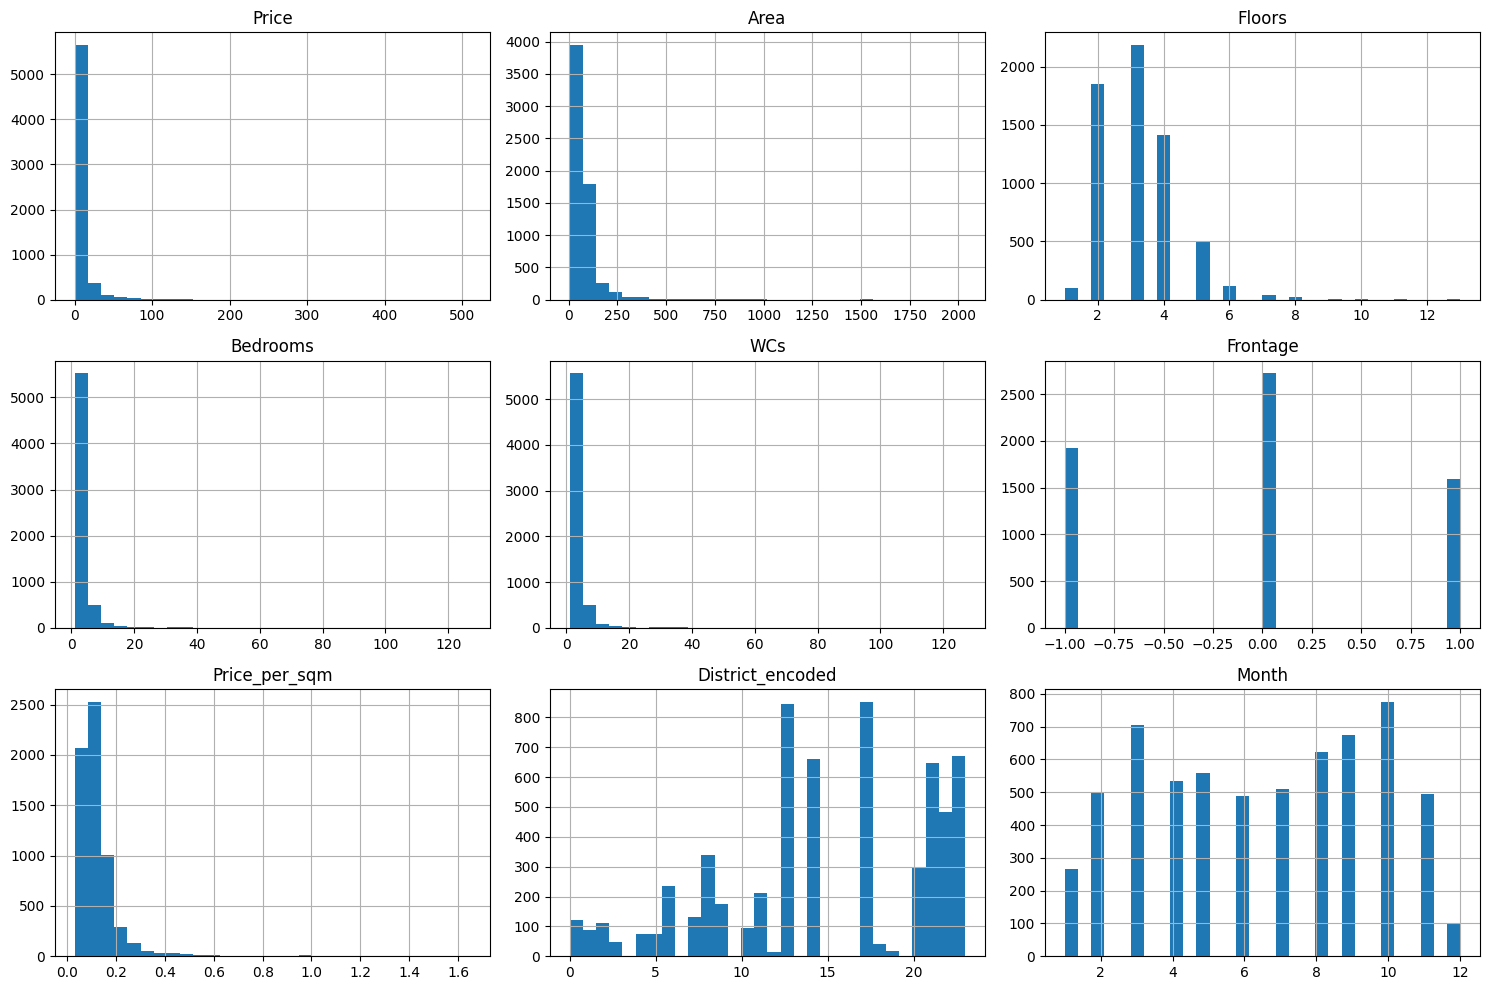

In [638]:
# Định nghĩa các biến số
numeric_features = ['Price', 'Area','Floors', 'Bedrooms', 'WCs', 'Frontage','Price_per_sqm', 'District_encoded', 'Month'  ]
# Vẽ Histogram cho các biến số
df[numeric_features].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

**Insights:**
*   Right-skewed distributions: For Price, Area, Price_per_sqm, Bedrooms, and WCs, the right-skewed distributions indicate that most properties fall within a lower range for these attributes, with fewer properties having significantly higher values.
*   Outliers: There are noticeable outliers, especially in the Price, Area, Bedrooms, and WCs features, which could affect modeling and analysis.
*   Uniform distributions: The more uniform distribution of District_encoded and Month suggests a balanced representation of districts and months in dataset.

                     Price      Area    Floors  Bedrooms       WCs  Frontage  \
Price             1.000000  0.677249  0.350912  0.414148  0.381549  0.083559   
Area              0.677249  1.000000  0.237480  0.488026  0.482390  0.093740   
Floors            0.350912  0.237480  1.000000  0.358992  0.358843  0.133431   
Bedrooms          0.414148  0.488026  0.358992  1.000000  0.923139  0.067450   
WCs               0.381549  0.482390  0.358843  0.923139  1.000000  0.059249   
Frontage          0.083559  0.093740  0.133431  0.067450  0.059249  1.000000   
Price_per_sqm     0.489012  0.013822  0.315616  0.149340  0.142473  0.090872   
District_encoded -0.128736 -0.016676 -0.093593 -0.044825 -0.037002 -0.047819   
Month             0.021979 -0.002706  0.003802  0.008406 -0.007808  0.007312   

                  Price_per_sqm  District_encoded     Month  
Price                  0.489012         -0.128736  0.021979  
Area                   0.013822         -0.016676 -0.002706  
Floors       

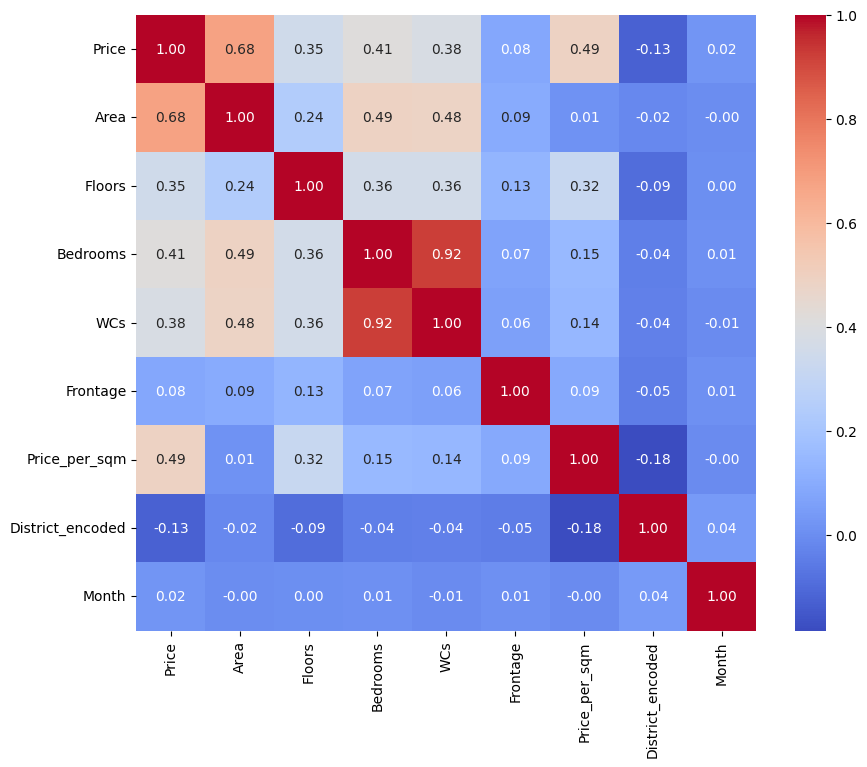

In [639]:
# Tính toán ma trận tương quan mà không bao gồm cột 'Price_per_sqm'
corr_matrix = df[numeric_features].corr()

# Hiển thị ma trận tương quan
print(corr_matrix)

# Vẽ Heatmap cho ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()



*   The area of the property is the most significant factor affecting the price, with a strong correlation of 0.68.
*   The number of bedrooms and WCs also significantly impact the price, with correlations of 0.41 and 0.38, respectively. Additionally, the number of floors shows a moderate impact with a correlation of 0.35.
*   Frontage has a minimal effect on the price, with a weak correlation of 0.08. The district has a slight negative correlation of -0.13, and the month shows almost no impact on the price, with a correlation of 0.02.








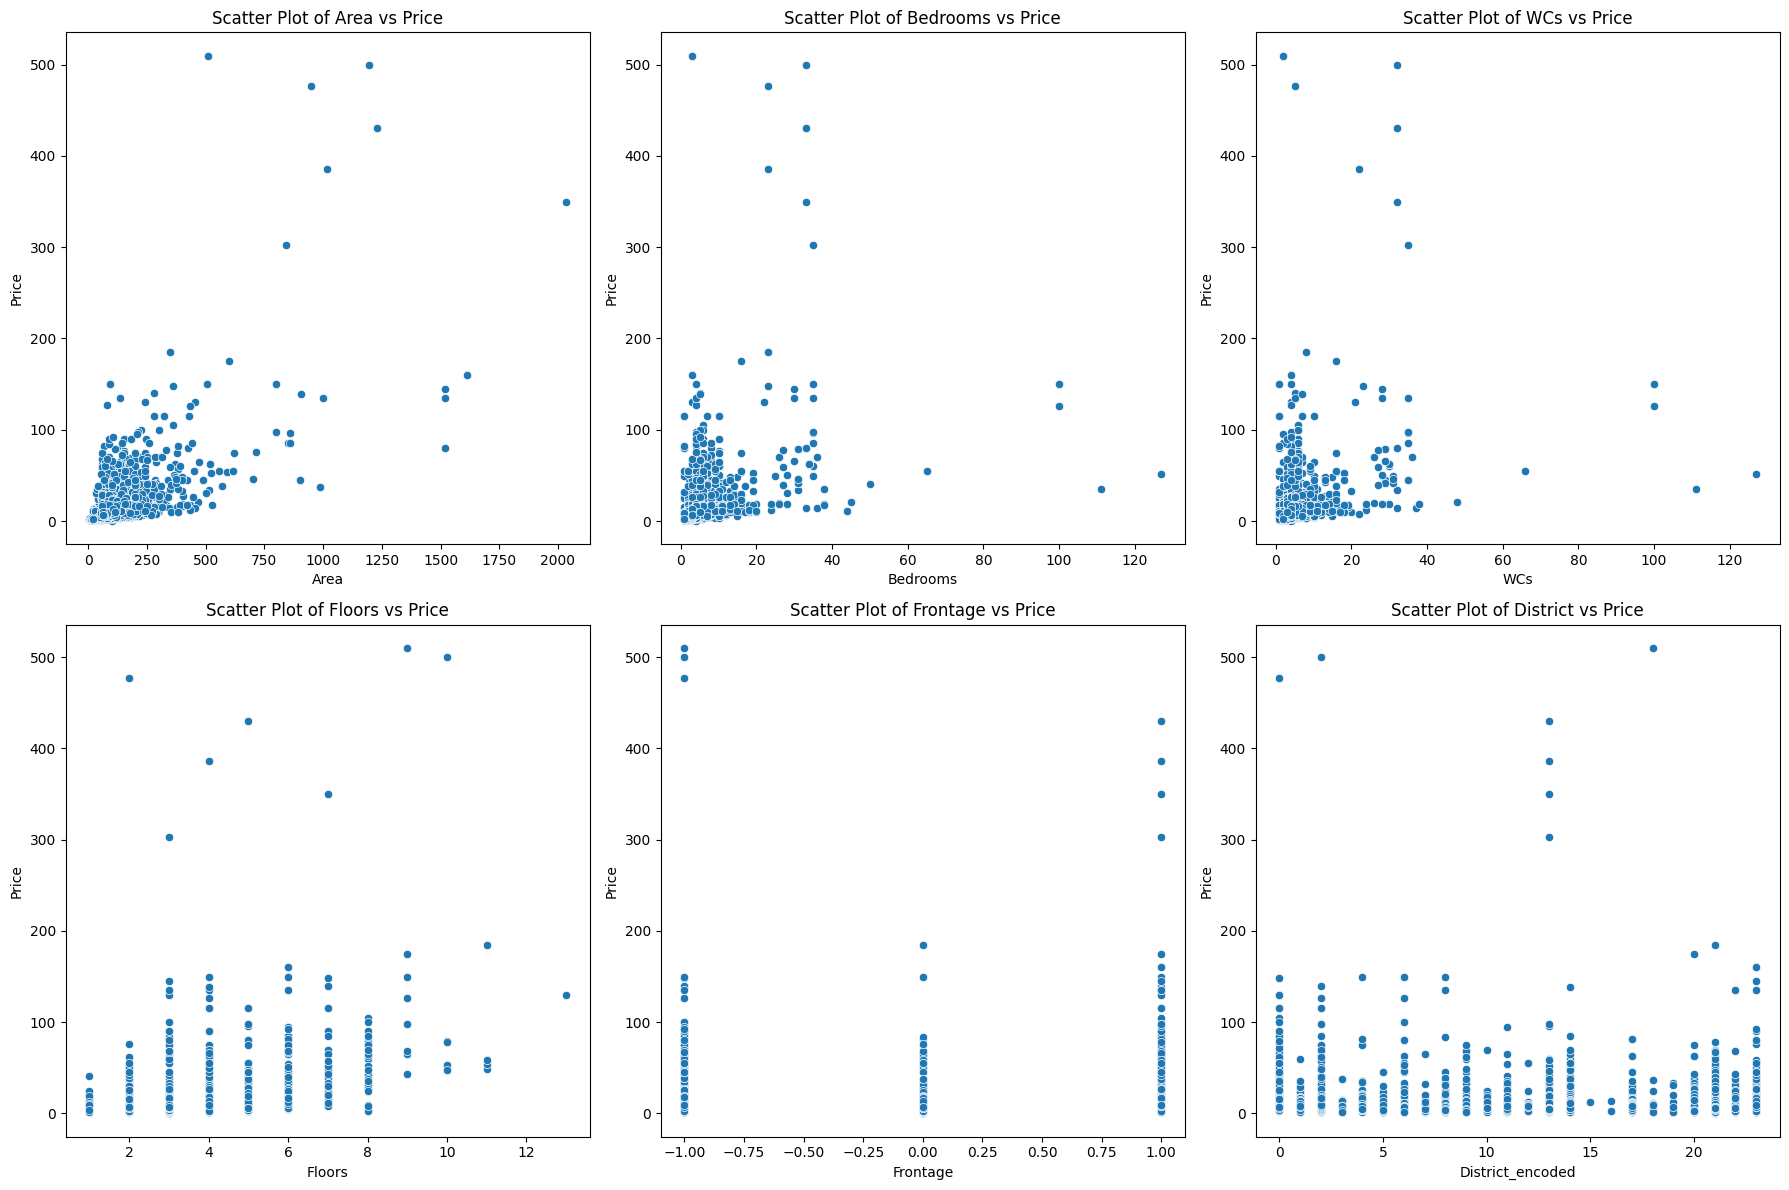

In [640]:
# Tạo một figure với sáu subplots trong hai hàng và ba cột
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Scatter plot giữa Area và Price
sns.scatterplot(x='Area', y='Price', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Scatter Plot of Area vs Price')

# Scatter plot giữa Bedrooms và Price
sns.scatterplot(x='Bedrooms', y='Price', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Scatter Plot of Bedrooms vs Price')

# Scatter plot giữa WCs và Price
sns.scatterplot(x='WCs', y='Price', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Scatter Plot of WCs vs Price')

# Scatter plot giữa Floors và Price
sns.scatterplot(x='Floors', y='Price', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Scatter Plot of Floors vs Price')

# Scatter plot giữa Frontage và Price
sns.scatterplot(x='Frontage', y='Price', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Scatter Plot of Frontage vs Price')

# Scatter plot giữa District_encoded và Price
sns.scatterplot(x='District_encoded', y='Price', data=df, ax=axes[1, 2])
axes[1, 2].set_title('Scatter Plot of District vs Price')

# Điều chỉnh layout
plt.tight_layout()
plt.show()



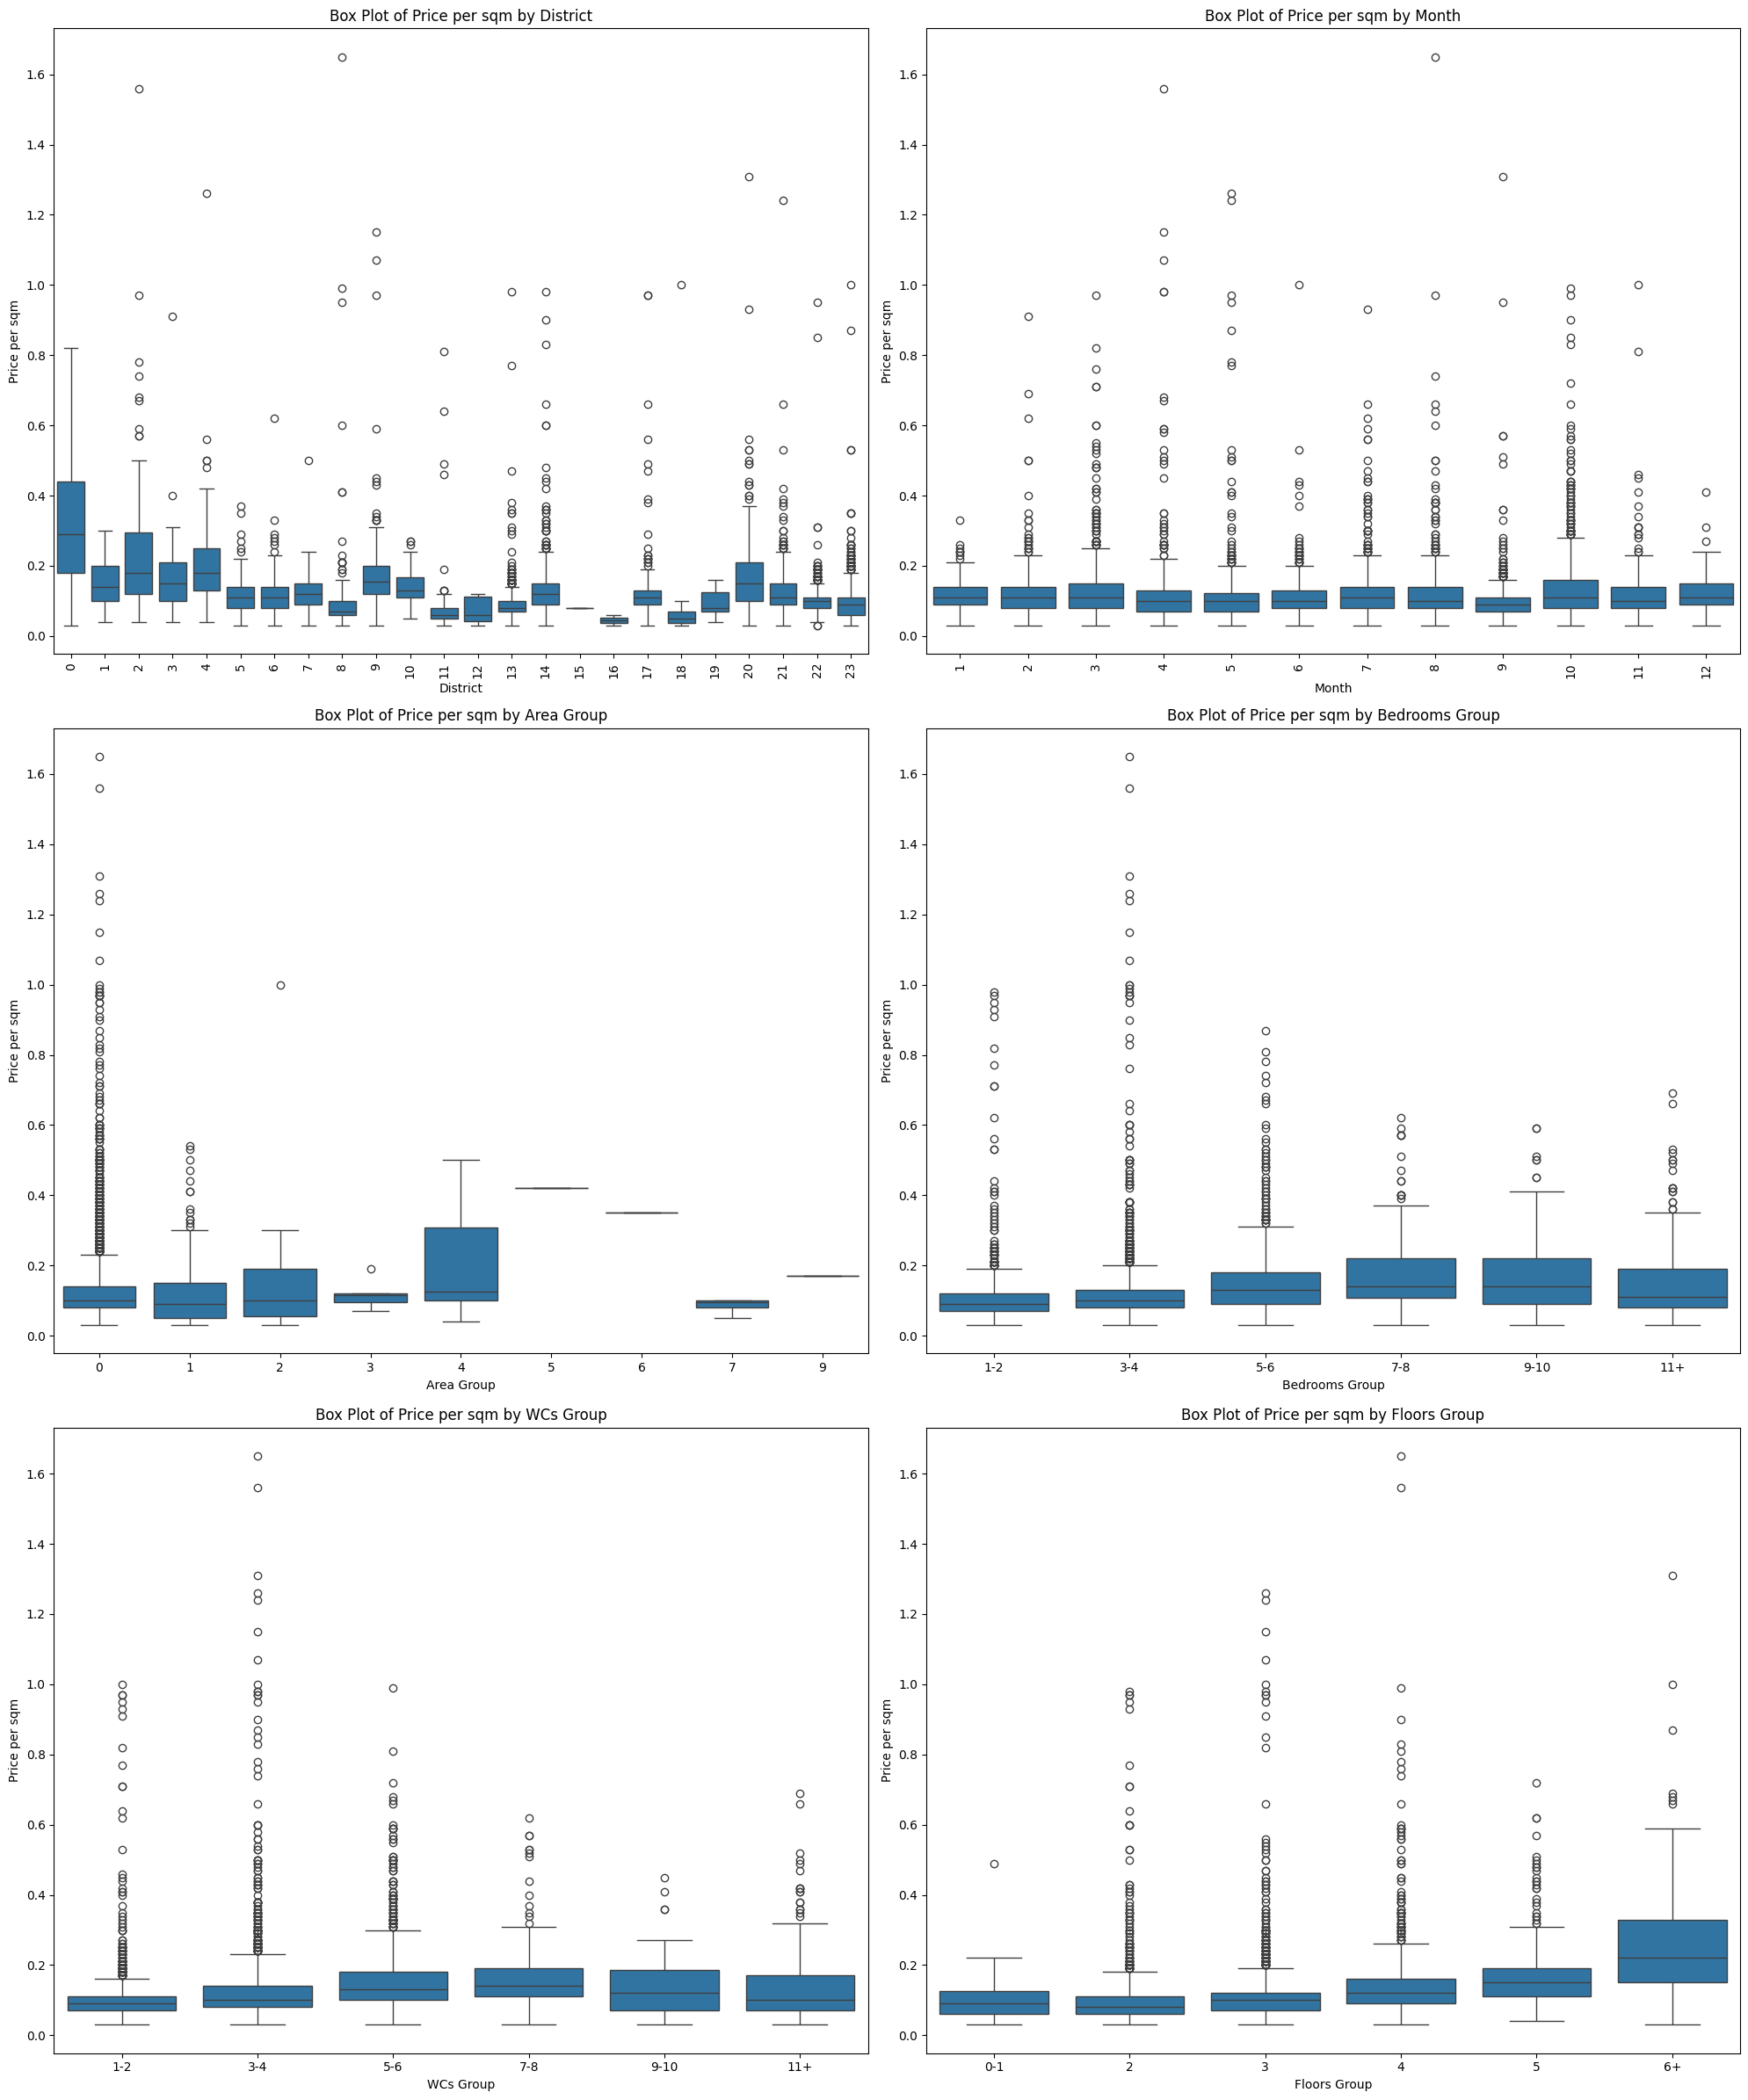

In [641]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chia Area thành các nhóm (bins) để dễ so sánh
df['Area_group'] = pd.cut(df['Area'], bins=10, labels=False)

# Group Bedrooms and WCs into fewer categories
df['Bedrooms_group'] = pd.cut(df['Bedrooms'], bins=[0, 2, 4, 6, 8, 10, float('inf')], labels=['1-2', '3-4', '5-6', '7-8', '9-10', '11+'])
df['WCs_group'] = pd.cut(df['WCs'], bins=[0, 2, 4, 6, 8, 10, float('inf')], labels=['1-2', '3-4', '5-6', '7-8', '9-10', '11+'])
df['Floors_group'] = pd.cut(df['Floors'], bins=[0, 1, 2, 3, 4, 5, float('inf')], labels=['0-1', '2', '3', '4', '5', '6+'])

# Tạo figure với nhiều subplot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 24))

# Box plot của Price theo District_encoded
sns.boxplot(ax=axes[0, 0], x='District_encoded', y='Price_per_sqm', data=df)
axes[0, 0].set_title('Box Plot of Price per sqm by District')
axes[0, 0].set_xlabel('District')
axes[0, 0].set_ylabel('Price per sqm')
axes[0, 0].tick_params(axis='x', rotation=90)

# Box plot của Price theo Month
sns.boxplot(ax=axes[0, 1], x='Month', y='Price_per_sqm', data=df)
axes[0, 1].set_title('Box Plot of Price per sqm by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Price per sqm')
axes[0, 1].tick_params(axis='x', rotation=90)

# Box plot của Price theo Area_group
sns.boxplot(ax=axes[1, 0], x='Area_group', y='Price_per_sqm', data=df)
axes[1, 0].set_title('Box Plot of Price per sqm by Area Group')
axes[1, 0].set_xlabel('Area Group')
axes[1, 0].set_ylabel('Price per sqm')

# Box plot của Price theo Bedrooms group
sns.boxplot(ax=axes[1, 1], x='Bedrooms_group', y='Price_per_sqm', data=df)
axes[1, 1].set_title('Box Plot of Price per sqm by Bedrooms Group')
axes[1, 1].set_xlabel('Bedrooms Group')
axes[1, 1].set_ylabel('Price per sqm')

# Box plot của Price theo WCs group
sns.boxplot(ax=axes[2, 0], x='WCs_group', y='Price_per_sqm', data=df)
axes[2, 0].set_title('Box Plot of Price per sqm by WCs Group')
axes[2, 0].set_xlabel('WCs Group')
axes[2, 0].set_ylabel('Price per sqm')

# Box plot của Price theo Floors group
sns.boxplot(ax=axes[2, 1], x='Floors_group', y='Price_per_sqm', data=df)
axes[2, 1].set_title('Box Plot of Price per sqm by Floors Group')
axes[2, 1].set_xlabel('Floors Group')
axes[2, 1].set_ylabel('Price per sqm')

plt.tight_layout()
plt.show()



*   Price by District:
     + Significant variation in house prices across districts.
     + Presence of high outliers in some districts.
*   Price by Month:
     + Fairly even distribution of prices across months.
     + Some months have high outliers.
*   Price by Area Group:
     + Prices tend to increase with larger area groups.
     + Higher area groups show more high outliers.
*   Price by Bedrooms:
     + More bedrooms generally correlate with higher prices, but with many outliers.
     + Higher bedroom counts (e.g., 9-10, 11+) show higher median prices.
*   Price by WCs:
     + More WCs tend to correlate with higher prices, but with many outliers.
     + Higher WC counts (e.g., 9-10, 11+) show higher median prices.
*   Price by Floors:
     + More floors tend to correlate with higher prices, but with many outliers.
     + Higher floors counts (e.g., 6+ ) show higher median prices.

In [650]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Loại bỏ ngoại lệ cho cột Price
df_no_outliers = remove_outliers(df, 'Price')

# Xóa các cột không cần thiết
columns_to_drop = ['District', 'Postdate','Description','Area_group', 'Bedrooms_group', 'WCs_group', 'Floors_group']
df_no_outliers = df_no_outliers.drop(columns=columns_to_drop)
# Xóa cột No hiện tại nếu tồn tại và thêm cột No mới
df_no_outliers = df_no_outliers.drop(columns=['No'], errors='ignore')

df_no_outliers.insert(0, 'No', range(1, len(df_no_outliers) + 1))

# Kiểm tra kết quả
print(df_no_outliers.describe())


             No        Price         Area     Bedrooms          WCs  \
count  5708.000  5708.000000  5708.000000  5708.000000  5708.000000   
mean   2854.500     6.632874    68.305242     3.602488     3.387701   
std    1647.902     3.439563    39.703702     2.039776     1.936481   
min       1.000     0.124000     5.000000     1.000000     1.000000   
25%    1427.750     4.200000    45.000000     2.000000     2.000000   
50%    2854.500     5.695000    60.000000     3.000000     3.000000   
75%    4281.250     8.300000    80.000000     4.000000     4.000000   
max    5708.000    18.000000   525.000000    44.000000    37.000000   

            Floors  Legal_status     Frontage  Price_per_sqm  \
count  5708.000000   5708.000000  5708.000000    5708.000000   
mean      3.047302      0.135599    -0.078486       0.107270   
std       1.001421      0.990851     0.726581       0.052508   
min       1.000000     -1.000000    -1.000000       0.030000   
25%       2.000000     -1.000000    -1.0

In [652]:
# Chuẩn bị các cột cần chuẩn hóa
columns_to_scale = ['Price', 'Area', 'Bedrooms', 'WCs', 'District_encoded', 'Month', 'Floors', 'Frontage', 'Legal_status']

# Tạo đối tượng StandardScaler
scaler = StandardScaler()

# Áp dụng chuẩn hóa cho các cột đã chọn
df_scaled = df_no_outliers.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_no_outliers[columns_to_scale])

# Kiểm tra kết quả
print(df_scaled.head())


    No     Price      Area  Bedrooms       WCs    Floors  Legal_status  \
3    1  1.996686 -0.612219 -0.295395 -0.200227  1.950098     -1.146186   
6    2  0.601038 -0.587030 -0.295395 -0.200227  0.951430      0.872459   
8    3  0.775494 -0.712974  0.194897  0.316219  0.951430      0.872459   
22   4  2.432826  2.100360  0.685190  0.316219 -0.047239     -1.146186   
23   5  2.723586  2.100360  0.685190  0.316219 -0.047239     -1.146186   

    Frontage  Price_per_sqm  District_encoded     Month  
3   1.484461           0.31         -2.528913  1.478346  
6   0.108031           0.19         -2.528913  1.478346  
8   0.108031           0.23         -2.528913  1.478346  
22  1.484461           0.10         -2.528913  1.155345  
23  1.484461           0.11         -2.528913  1.155345  


In [653]:
print(df_scaled.describe())

             No         Price          Area      Bedrooms           WCs  \
count  5708.000  5.708000e+03  5.708000e+03  5.708000e+03  5.708000e+03   
mean   2854.500 -2.464742e-16 -8.589252e-17 -6.473059e-17 -5.975132e-17   
std    1647.902  1.000088e+00  1.000088e+00  1.000088e+00  1.000088e+00   
min       1.000 -1.892520e+00 -1.594581e+00 -1.275981e+00 -1.233118e+00   
25%    1427.750 -7.073825e-01 -5.870305e-01 -7.856881e-01 -7.166726e-01   
50%    2854.500 -2.726962e-01 -2.091989e-01 -2.953954e-01 -2.002268e-01   
75%    4281.250  4.847337e-01  2.945766e-01  1.948974e-01  3.162190e-01   
max    5708.000  3.305106e+00  1.150358e+01  1.980661e+01  1.735893e+01   

             Floors  Legal_status      Frontage  Price_per_sqm  \
count  5.708000e+03  5.708000e+03  5.708000e+03    5708.000000   
mean   1.058096e-16 -5.477204e-17  5.726168e-17       0.107270   
std    1.000088e+00  1.000088e+00  1.000088e+00       0.052508   
min   -2.044576e+00 -1.146186e+00 -1.268399e+00       0.0300

In [654]:
# Xuất dữ liệu đã xử lý ra file CSV mới
df_scaled.to_csv('../Data/preprocessed_data.csv', index=False)